# Detecting Vessels Using Sentinel-2 Images in Amazon SageMaker 

### Table of contents
1. [Introduction to dataset](#introduction)
2. [Labeling with Amazon SageMaker Ground Truth](#groundtruth)
3. [Reviewing labeling results](#review)
4. [Training an Object Detection model](#training)
5. [Review of Training Results](#review_training)
6. [Model Tuning](#model_tuning)
7. [Cleanup](#cleanup)



<a name="introduction"></a>
## Introduction to dataset
* We will use Sentinel-2 satellite images downloaded from Copernicus Hub. 
* The images are published as square granules of 110km by 110km. 
* Vancouver and Houston are the two areas of interest. 10 images per location.
* Since we only are interested in bands in the visible spectrum, we use bands 2,3 and 4.
* We used QGIS to determine the extent of the image and generate a grid of 2km by 2km
* Identify in what places of the grid we see more vessels
* In Vancouver we selected 15 squares, as a result we have 150 tiles 
* In Houston we selected 42 squares, as a result we have 420 tiles
* Each tile is 200 by 200 pixels
* Use Python GDAL to cut the original images into small tiles. See slicing_s2.

## Labeling with SageMaker Ground Truth <a name="groundtruth"></a>

To configure the labeling UI tool, we use the following information:

- Brief task description: _"Draw a bounding box around the **vessels** in this image."_
- Labels: _"small-vessel"_ _"large-vessel"_
- Good example description: _"A bounding box for each vessel. Must include all visible footprint of the vessel, except its trace on the water. Two label categories are needed: large vessels (examples in red), and small vessels (examples in yellow)"_
- Good example image: https://s2-tiles.s3.us-east-2.amazonaws.com/label-examples/good_example.png
- Bad example description: _"Bounding box is too big and/or shifted and/or excludes part of the structure"_
- Bad example image: https://s2-tiles.s3.us-east-2.amazonaws.com/label-examples/bad_example.png

## Reviewing labeling results
<a name="reviewing"></a>

After the labeling job has completed, we can see the results of image annotations right in the SageMaker console itself. The console displays each image as well as the bounding boxes around the vessels that were drawn by human labelers.

At the same time we can examine the results in the augmented manifest file that was generated. Let's download and examine the manifest file.

In [39]:
# Enter the name of your job here
labeling_job_name = 'vessels-samples'

import boto3
client = boto3.client('sagemaker')

s3_output = client.describe_labeling_job(LabelingJobName=labeling_job_name)['OutputConfig']['S3OutputPath'] + labeling_job_name
augmented_manifest_url = f'{s3_output}/manifests/output/output.manifest'

import os
import shutil

try:
    os.makedirs('od_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('od_output_data/')

# now download the augmented manifest file and display first 3 lines
!aws s3 cp $augmented_manifest_url od_output_data/
augmented_manifest_file = 'od_output_data/output.manifest'
!head -3 $augmented_manifest_file

download: s3://s2-tiles/output/vessels-samples/manifests/output/output.manifest to od_output_data/output.manifest
{"source-ref":"s3://s2-tiles/input/T10UDV_20190317T191121_2765.png","vessels-samples":{"annotations":[{"class_id":0,"width":31,"top":127,"height":15,"left":119},{"class_id":0,"width":8,"top":155,"height":11,"left":192},{"class_id":1,"width":13,"top":189,"height":8,"left":156}],"image_size":[{"width":200,"depth":3,"height":200}]},"vessels-samples-metadata":{"job-name":"labeling-job/vessels-samples","class-map":{"1":"small-vessel","0":"large-vessel"},"human-annotated":"yes","objects":[{"confidence":0.09},{"confidence":0.09},{"confidence":0.09}],"creation-date":"2020-04-22T14:06:07.244728","type":"groundtruth/object-detection"}}
{"source-ref":"s3://s2-tiles/input/T10UDV_20190317T191121_2766.png","vessels-samples":{"annotations":[{"class_id":0,"width":26,"top":11,"height":4,"left":141},{"class_id":1,"width":6,"top":155,"height":9,"left":45}],"image_size":[{"width":200,"depth":3

Now let's plot some of the annotated images. First, let's define a function that displays the local image file and draws over it the bounding boxes obtained via labeling.

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Next, read the augmented manifest (JSON lines format) line by line and display the first 10 images.

input-tiles/T10UDV_20190317T191121_2765.png


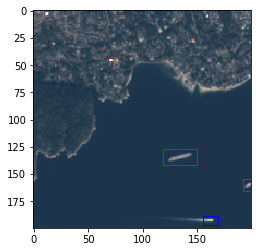

input-tiles/T10UDV_20190317T191121_2766.png


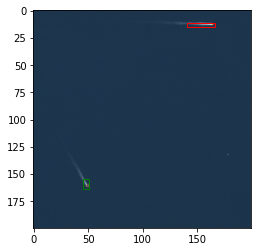

input-tiles/T10UDV_20190317T191121_2767.png


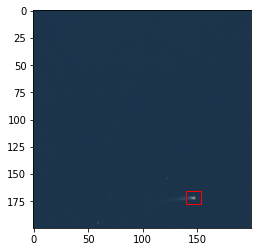

input-tiles/T10UDV_20190317T191121_2768.png


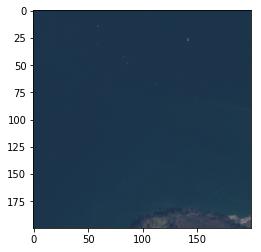

input-tiles/T10UDV_20190317T191121_2826.png


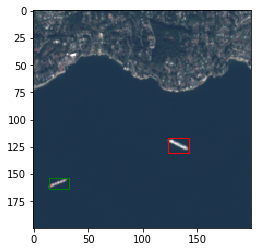

input-tiles/T10UDV_20190317T191121_2827.png


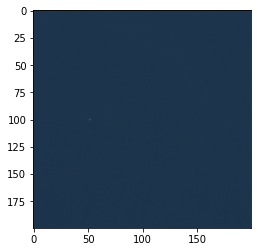

input-tiles/T10UDV_20190317T191121_2828.png


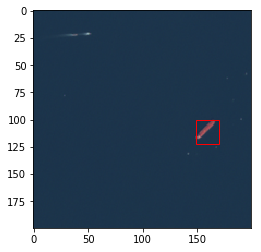

input-tiles/T10UDV_20190317T191121_2829.png


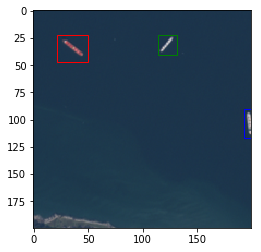

input-tiles/T10UDV_20190317T191121_2888.png


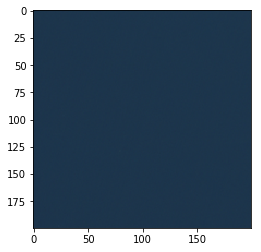

input-tiles/T10UDV_20190317T191121_2889.png


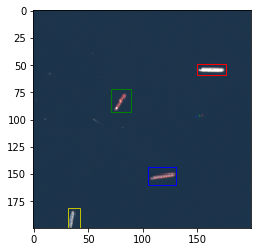

In [41]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines
from itertools import islice

tiles_base_path = 'input-tiles/'

with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref'] # within the manifest, not absolute path
        img_file = os.path.basename(img_url)
        img_path = tiles_base_path+img_file
        bboxes = desc[labeling_job_name]['annotations']
        
        if os.path.isfile(img_path):
            print(img_path)
            bboxes = desc[labeling_job_name]['annotations']
            show_annotated_image(img_path, bboxes)

<a name='training'></a>
## Training an Object Detection Model
We are now ready to use the labeled dataset in order to train a Machine Learning model using the SageMaker [built-in Object Detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

For this, we would need to split the full labeled dataset into a training, validation, and test sets. 

Out of the total of 570 tiles we are going to use 

Set | Number of tiles | Percentage |
--|--|--|
Training | 456 | 80% |
Validation | 57 | 10% |
Test | 57 | 10% |

In [44]:
import json

with jsonlines.open('od_output_data/output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.seed(seed=1)
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)
num_remaining = dataset_size-num_training_samples
num_val_samples = round(num_remaining*0.5)
num_test_samples = dataset_size - num_training_samples - num_val_samples

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:(num_training_samples+num_val_samples)]
test_data= lines[(num_training_samples+num_val_samples):]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_test = 'test.manifest'

with open(augmented_manifest_filename_test, 'w') as f:
    for line in test_data:
        f.write(json.dumps(line))
        f.write('\n')
        
        
print(f'training samples: {len(train_data)}, validation samples: {len(validation_data)}, test samples: {len(test_data)}')


training samples: 456, validation samples: 57, test samples: 57


In [48]:
BUCKET = 's2-tiles'
PREFIX = 'output/data-splits' # this is the root path to your working space, feel to use a different path

Next, let's upload the three manifest files to S3 in preparation for training. We will use the same bucket.

In [49]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)
s3_test_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_test)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp test.manifest s3://$BUCKET/$pfx_training/

upload: ./train.manifest to s3://s2-tiles/output/data-splits/training/train.manifest
upload: ./validation.manifest to s3://s2-tiles/output/data-splits/training/validation.manifest
upload: ./test.manifest to s3://s2-tiles/output/data-splits/training/test.manifest


Now we launch the training job using the **SageMaker console**.

In [50]:
import boto3
client = boto3.client('sagemaker')

In [68]:
##### REPLACE WITH YOUR OWN TRAINING JOB NAME
# In the above console screenshots the job name was 'vessel-training-job'.
# But if you used Python to kick off the training job,
# then 'training_job_name' is already set, so you can comment out the line below.
training_job_name = 'vessel-training-job'
##### REPLACE WITH YOUR OWN TRAINING JOB NAME

training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])

Training job status:  Completed
Secondary status:  Completed


<a name='review_training'></a>

## Review of Training Results

First, let's create the SageMaker model out of model artifacts

In [69]:
import time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = training_job_name + '-model' + timestamp

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

from sagemaker import get_execution_role

role = get_execution_role()

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-2:372049120833:model/vessel-training-job-model-2020-04-25-20-17-24


In [70]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: vessel-training-job-epc-2020-04-25-20-18-04
Endpoint configuration arn:  arn:aws:sagemaker:us-east-2:372049120833:endpoint-config/vessel-training-job-epc-2020-04-25-20-18-04


### Create Endpoint

The next cell creates an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [71]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = training_job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: vessel-training-job-ep-2020-04-25-20-18-45
EndpointArn = arn:aws:sagemaker:us-east-2:372049120833:endpoint/vessel-training-job-ep-2020-04-25-20-18-45


In [74]:
# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

EndpointStatus = InService


### Perform inference

We use the deployed endpoint to detect vessels in the test images 

In [75]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines

In [76]:
test_images_s3 = []
with jsonlines.open('test.manifest', 'r') as reader:
    lines = list(reader)
    for line in lines:
        test_images_s3.append(line['source-ref'])
test_images_s3[:3]

['s3://s2-tiles/input/T15RUN_20200124T165559_1680.png',
 's3://s2-tiles/input/T15RUN_20190409T164849_1128.png',
 's3://s2-tiles/input/T15RUN_20191031T165431_2049.png']

In [77]:
import os

test_images = []
base_folder = 'input-tiles/'

for img in test_images_s3:
    test_images.append(base_folder+os.path.basename(img))

print(test_images[0])

input-tiles/T15RUN_20200124T165559_1680.png


Next, define a function that converts the prediction array returned by our endpoint to the bounding box structure expected by our image display function.

In [78]:
from PIL import Image
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

Finally, for each of the test images, the following cell transforms the image into the appropriate format for realtime prediction, repeatedly calls the endpoint, receives back the prediction, and displays the result.

input-tiles/T15RUN_20200124T165559_1680.png


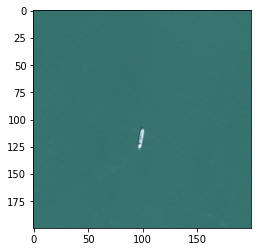

input-tiles/T15RUN_20190409T164849_1128.png


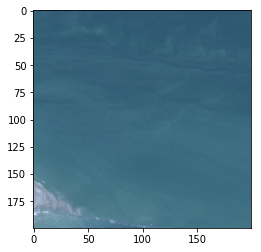

input-tiles/T15RUN_20191031T165431_2049.png


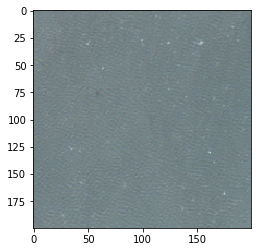

input-tiles/T15RUN_20191110T165531_1741.png


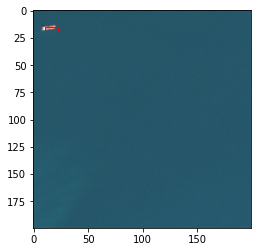

input-tiles/T15RUN_20190906T164849_1067.png


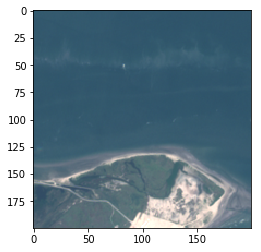

input-tiles/T10UDV_20200316T191029_2828.png


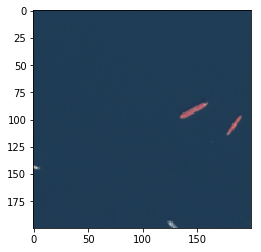

input-tiles/T10UDV_20190327T191021_2829.png


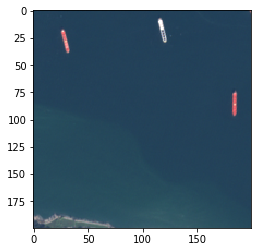

input-tiles/T15RUN_20190906T164849_1188.png


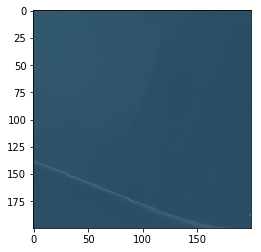

input-tiles/T15RUN_20191230T165711_1804.png


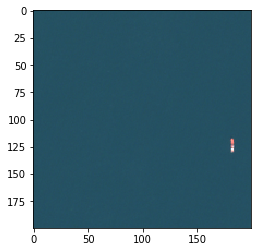

input-tiles/T15RUN_20191110T165531_1189.png


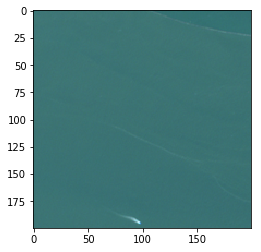

input-tiles/T10UDV_20190327T191021_2890.png


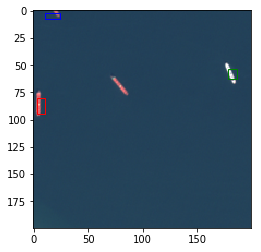

input-tiles/T15RUN_20190414T164901_1127.png


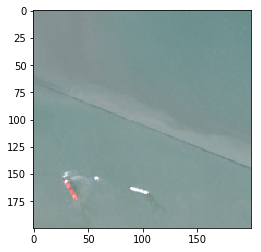

input-tiles/T10UDV_20190804T190921_2826.png


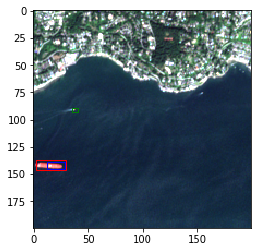

input-tiles/T10UDV_20190327T191021_2765.png


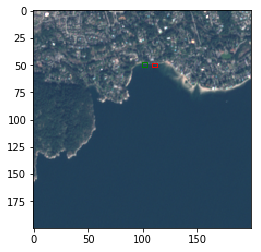

input-tiles/T15RUN_20191230T165711_1742.png


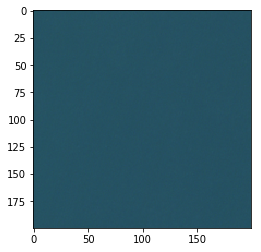

input-tiles/T15RUN_20190906T164849_1741.png


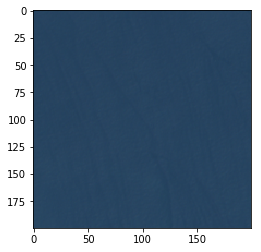

input-tiles/T15RUN_20191031T165431_1681.png


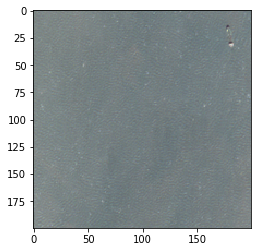

input-tiles/T10UDV_20190327T191021_2949.png


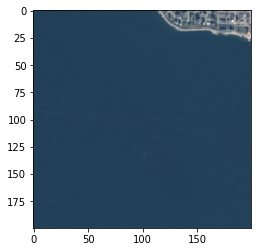

input-tiles/T10UDV_20190531T190919_2951.png


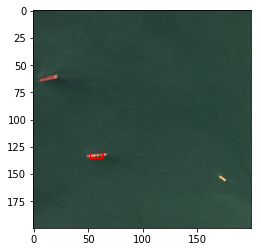

input-tiles/T15RUN_20200104T165709_1557.png


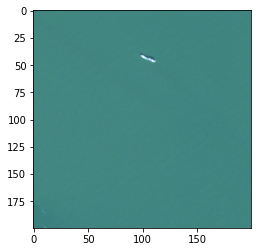

input-tiles/T15RUN_20200104T165709_1863.png


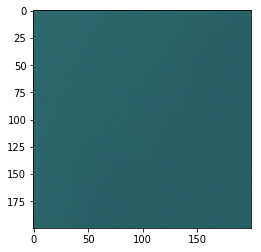

input-tiles/T15RUN_20200124T165559_1679.png


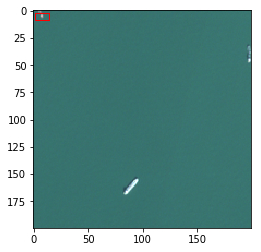

input-tiles/T15RUN_20191230T165711_1556.png


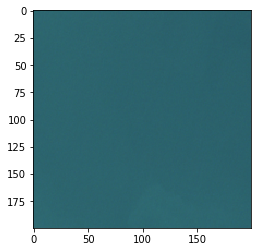

input-tiles/T15RUN_20191110T165531_1804.png


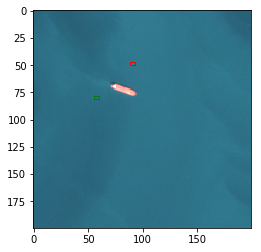

input-tiles/T10UDV_20190804T190921_2949.png


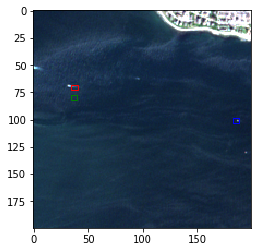

input-tiles/T15RUN_20191230T165711_1617.png


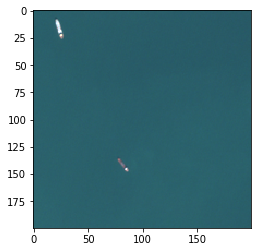

input-tiles/T15RUN_20191115T165549_1863.png


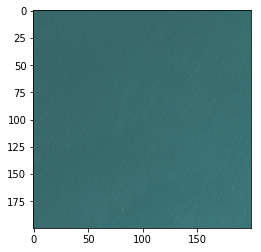

input-tiles/T15RUN_20190901T164901_1864.png


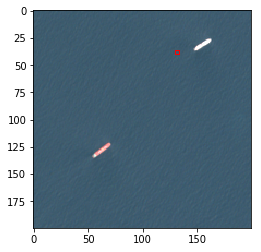

input-tiles/T15RUN_20190414T164901_1680.png


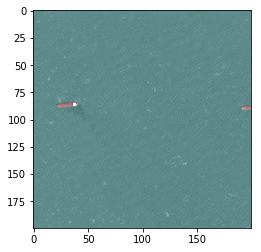

input-tiles/T15RUN_20190906T164849_944.png


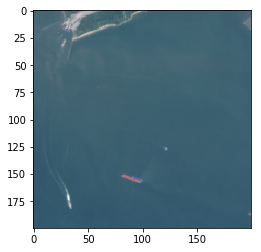

input-tiles/T15RUN_20200104T165709_1804.png


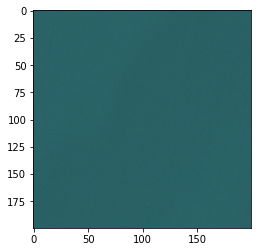

input-tiles/T15RUN_20190906T164849_1988.png


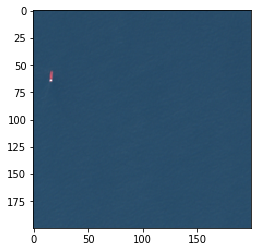

input-tiles/T15RUN_20200124T165559_1188.png


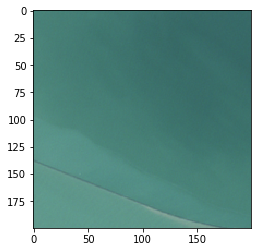

input-tiles/T15RUN_20191031T165431_1006.png


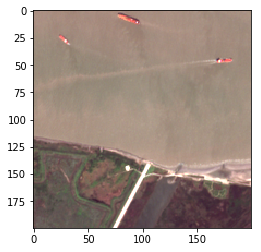

input-tiles/T10UDV_20190317T191121_2829.png


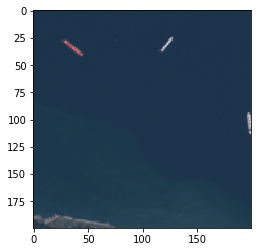

input-tiles/T15RUN_20191110T165531_1925.png


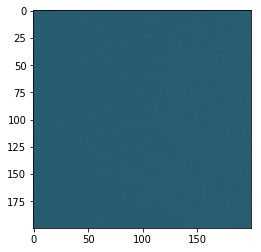

input-tiles/T10UDV_20200321T191051_2828.png


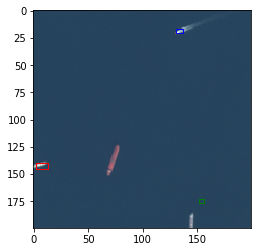

input-tiles/T10UDV_20200220T191421_2949.png


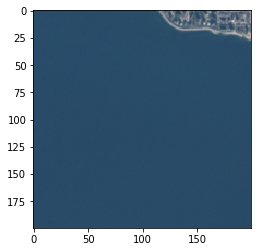

input-tiles/T15RUN_20191230T165711_1926.png


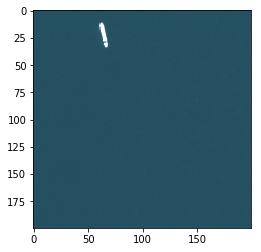

input-tiles/T15RUN_20200104T165709_1680.png


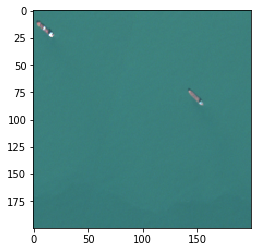

input-tiles/T15RUN_20190414T164901_1743.png


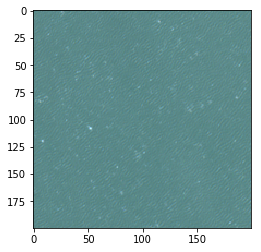

input-tiles/T15RUN_20191110T165531_2049.png


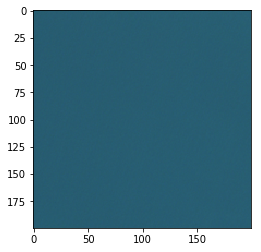

input-tiles/T15RUN_20200104T165709_1127.png


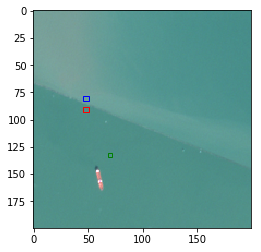

input-tiles/T15RUN_20190901T164901_1681.png


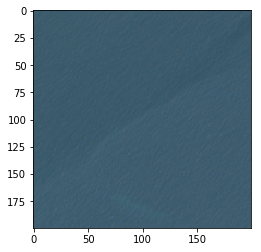

input-tiles/T15RUN_20191230T165711_1801.png


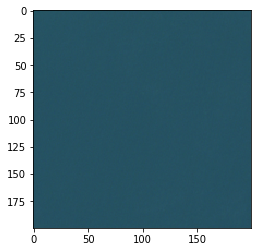

input-tiles/T15RUN_20191031T165431_883.png


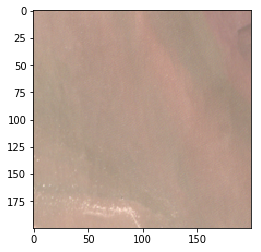

input-tiles/T15RUN_20190901T164901_1740.png


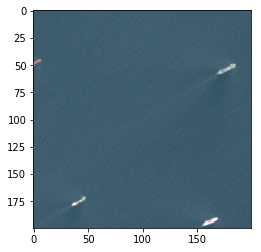

input-tiles/T15RUN_20190906T164849_1005.png


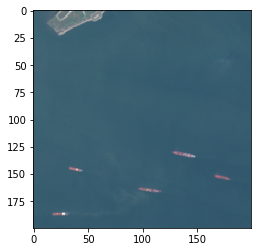

input-tiles/T15RUN_20190409T164849_1805.png


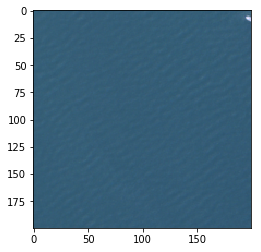

input-tiles/T15RUN_20190906T164849_1128.png


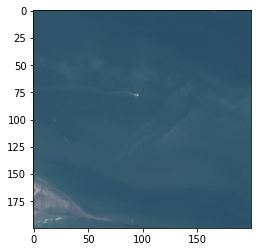

input-tiles/T15RUN_20191110T165531_1864.png


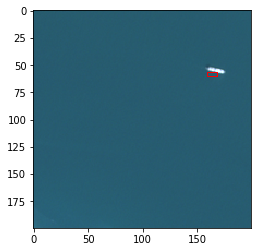

input-tiles/T15RUN_20200104T165709_1742.png


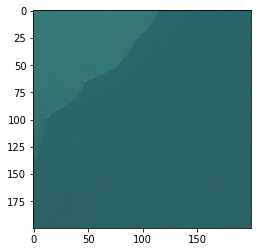

input-tiles/T10UDV_20200316T191029_2889.png


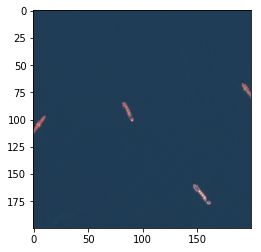

input-tiles/T10UDV_20200321T191051_2889.png


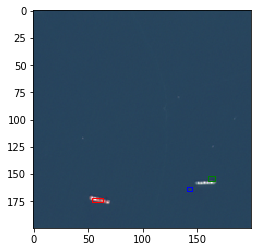

input-tiles/T10UDV_20190804T190921_2950.png


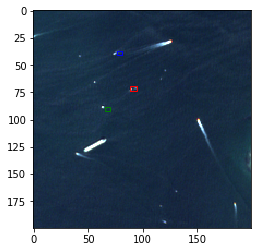

input-tiles/T15RUN_20190901T164901_1006.png


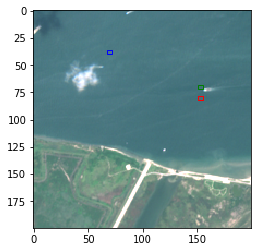

input-tiles/T10UDV_20190531T190919_2829.png


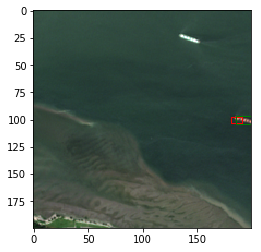

In [79]:
import matplotlib.pyplot as plt


runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .2
    best_n = 3
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    print(test_image)
    show_annotated_image(test_image, bboxes)

<a name='cleanup'></a>
## Cleanup

We delete the real-time endpoint if not needed anymore.

In [80]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '52631d3a-1772-48d9-b31d-d8ddedf2e907',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '52631d3a-1772-48d9-b31d-d8ddedf2e907',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 25 Apr 2020 20:29:49 GMT'},
  'RetryAttempts': 0}}